## MILP-Based Optimal Drone Assignment Strategy - Mathematical Optimization Algorithm

### Algorithm Type: **Mixed-Integer Linear Programming (MILP) Optimization**

The MILP-Based Optimal Drone Assignment Strategy implements a **Mathematical Optimization Algorithm** that formulates the drone-task assignment problem as a Mixed-Integer Linear Programming problem and finds the globally optimal solution using SciPy's optimization capabilities.

### Mathematical Formulation:

#### **Sets:**
- $I$: Set of available drones (drone fleet)
- $J$: Set of pending tasks (delivery requests)

#### **Parameters:**
- $\bar{d}_{ij} \geq 0$: Normalized total flight distance for drone $i$ to handle task $j$ (round-trip)
- $\bar{e}_{ij} \geq 0$: Normalized energy consumption (Wh) required for the assignment
- $\bar{A}_j \geq 0$: Normalized priority/value of task $j$
- $E_i^{\max} > 0$: Available battery capacity (Wh) for drone $i$
- $\sigma \in [0,1)$: Safety margin ratio (e.g., $\sigma=0.2$ reserves 20% battery)
- $w_{ij} \in \{0,1\}$: Distance gate (1 if task $j$ is within drone $i$'s operational range, 0 otherwise)
- $Q_i \in \mathbb{Z}^+$: Maximum concurrent tasks per drone $i$ (typically $Q_i = 1$)
- $\alpha, \beta, \gamma \geq 0$: Weight coefficients for distance, energy, and priority optimization terms
- $\rho_j \geq 0$: Penalty cost for dropping/deferring task $j$

#### **Normalization (for balanced optimization):**
- $\bar{d}_{ij} = \frac{d_{ij}}{D_{\max}}$: Distance normalized by maximum distance
- $\bar{e}_{ij} = \frac{e_{ij}}{E_i^{\max}}$: Energy normalized by drone's battery capacity
- $\bar{A}_j = \frac{A_j}{A_{\max}}$: Priority normalized by maximum task priority

#### **Decision Variables:**
- $x_{ij} \in \{0,1\}$: Binary assignment variable (1 if drone $i$ performs task $j$, 0 otherwise)
- $y_j \in \{0,1\}$: Binary drop variable (1 if task $j$ is dropped/deferred, 0 otherwise)

#### **Objective Function (Minimize):**

$$
\min \sum_{i \in I} \sum_{j \in J} \{\alpha \cdot \bar{d}_{ij} + \beta \cdot \bar{e}_{ij} - \gamma \cdot \bar{A}_j\} \cdot x_{ij} + \sum_{j \in J} \rho_j \cdot y_j
$$

**Interpretation:**
- $\alpha \cdot \bar{d}_{ij}$: Minimize total flight distances (operational efficiency)
- $\beta \cdot \bar{e}_{ij}$: Minimize energy consumption (battery optimization)
- $-\gamma \cdot \bar{A}_j$: Maximize task priority satisfaction (service quality)
- $\rho_j \cdot y_j$: Penalize task drops (completion rate optimization)

#### **Constraints:**

1. **Assignment Constraint**: Each task must be either assigned to exactly one drone or dropped
   $$
   \forall j \in J: \sum_{i \in I} x_{ij} + y_j = 1
   $$

2. **Capacity Constraint**: Each drone cannot exceed its concurrent task limit
   $$
   \forall i \in I: \sum_{j \in J} x_{ij} \leq Q_i
   $$

3. **Battery Constraint**: Total energy consumption must respect safety margins
   $$
   \forall i \in I: \sum_{j \in J} e_{ij} \cdot x_{ij} \leq (1-\sigma) \cdot E_i^{\max}
   $$

4. **Range Constraint**: Tasks outside operational range cannot be assigned
   $$
   \forall i \in I, \forall j \in J: x_{ij} \leq w_{ij}
   $$

### Key Characteristics:

**Mathematical Optimality**: 
- Guarantees globally optimal solution within the mathematical model constraints
- Considers all objectives and constraints simultaneously for best overall assignment
- Provides optimality certificates and solution quality guarantees

**Multi-Objective Optimization**: 
- Balances competing objectives (distance, energy, priority) through weighted coefficients
- Supports flexible priority schemes via adjustable parameters $\alpha$, $\beta$, $\gamma$
- Handles task importance through priority values and drop penalties

**Constraint Satisfaction**: 
- Rigorously enforces physical limitations (battery, range, capacity)
- Handles infeasible scenarios gracefully through task dropping mechanism
- Ensures mathematical feasibility and operational safety

### Drop Decision Mechanism:

**Task Drop Criteria ($\rho_j$ - Drop Penalty):**

The drop penalty $\rho_j$ determines when it's acceptable to defer/drop a task. The optimizer automatically decides to drop task $j$ when:

$$
\rho_j < \min_{i \in I} \{\alpha \cdot \bar{d}_{ij} + \beta \cdot \bar{e}_{ij} - \gamma \cdot \bar{A}_j\}
$$

**Practical Interpretation:**
- **High $\rho_j$ (e.g., $\rho_j = 10.0$)**: Force assignment even if inefficient → High completion rate, potentially suboptimal routes
- **Medium $\rho_j$ (e.g., $\rho_j = 1.0$)**: Balance between completion and efficiency → Drops only clearly infeasible tasks
- **Low $\rho_j$ (e.g., $\rho_j = 0.1$)**: Prefer efficiency over completion → Drops marginally inefficient tasks

**Drop Scenarios:**
1. **Physical Infeasibility**: All drones lack battery, capacity, or range (forced drop regardless of $\rho_j$)
2. **Economic Infeasibility**: Assignment cost exceeds drop penalty (optimizer-driven drop)
3. **Resource Optimization**: Better to drop low-priority tasks and serve high-priority ones efficiently

**Recommended $\rho_j$ Settings:**
- **Mission-Critical**: $\rho_j = 100 \times \max(\alpha, \beta, \gamma)$ (virtually never drop)
- **Balanced**: $\rho_j = 2 \times (\alpha + \beta + \gamma)$ (drop only when significantly inefficient)
- **Efficiency-First**: $\rho_j = 0.5 \times (\alpha + \beta + \gamma)$ (aggressive dropping for optimal fleet utilization)

### SciPy Implementation Strategy:

**Problem Formulation:**
```python
from scipy.optimize import milp, LinearConstraint, Bounds
import numpy as np

# Construct objective coefficients vector c
# Construct constraint matrices A_eq, A_ub  
# Define bounds and integrality constraints
# Solve using milp() function
```

**Key Implementation Steps:**
1. **Parameter Calculation**: Compute $d_{ij}$, $e_{ij}$, $w_{ij}$ for all drone-task pairs
2. **Matrix Construction**: Build constraint matrices for equality and inequality constraints
3. **Variable Ordering**: Organize $x_{ij}$ and $y_j$ variables in consistent indexing scheme
4. **Solver Invocation**: Use `scipy.optimize.milp` with appropriate solver parameters
5. **Solution Parsing**: Extract assignment decisions from optimal solution vector

### Use Cases:

**Mission-Critical Operations**: 
- Emergency response scenarios requiring optimal resource allocation
- High-value delivery services where solution quality justifies computation cost
- Military or medical drone operations with strict operational constraints

**Resource-Constrained Environments**: 
- Limited battery capacity requiring careful energy management
- Fleet operations with heterogeneous drone capabilities
- Operations in challenging geographical or regulatory environments

**Multi-Objective Scenarios**: 
- Balancing operational cost, service quality, and completion rates
- Optimizing for both immediate efficiency and long-term sustainability
- Complex prioritization schemes with varying task importance levels

### Algorithm Steps:
1. **State Assessment**: Evaluate current drone positions, battery levels, and task queues
2. **Parameter Computation**: Calculate distance, energy, and feasibility parameters for all drone-task pairs
3. **MILP Formulation**: Construct objective function and constraint matrices
4. **Optimization**: Solve MILP using SciPy's `milp` solver with appropriate time limits
5. **Solution Execution**: Implement optimal assignments and handle dropped tasks
6. **Monitoring**: Track solution quality and computational performance for tuning

### Trade-offs:

**Advantages:**
- **Guaranteed Optimality**: Mathematical proof of solution quality within model assumptions
- **Comprehensive Constraint Handling**: Rigorous enforcement of all operational limitations
- **Flexible Objective Function**: Supports complex multi-criteria optimization scenarios
- **Robust Infeasibility Handling**: Graceful management of impossible assignment scenarios
- **Scalable Parameter Tuning**: Easy adjustment of optimization priorities through weight parameters

**Disadvantages:**
- **Computational Complexity**: Potentially exponential solution time for large problem instances
- **Real-time Limitations**: May require solution time limits for time-critical applications
- **Implementation Complexity**: Requires mathematical optimization expertise and careful debugging
- **Modeling Assumptions**: Solution quality depends on accuracy of distance/energy models
- **Scalability Constraints**: Performance degrades with very large drone fleets or task sets

### Comparison with Heuristic Strategies:

**vs Fair Assignment (Round-Robin):**
- **Quality**: Optimal vs guaranteed fairness
- **Efficiency**: Minimized operational cost vs balanced workload
- **Complexity**: High computational cost vs O(1) assignment time

**vs Nearest Assignment (Greedy):**
- **Quality**: Global optimization vs local distance minimization
- **Constraints**: Full constraint satisfaction vs simple feasibility checks
- **Scalability**: Solver-dependent vs linear time complexity

**vs Optimal Distance (Route-based):**
- **Scope**: Multi-objective optimization vs single distance criterion
- **Constraints**: Mathematical constraint handling vs heuristic feasibility
- **Guarantees**: Provable optimality vs approximate solutions

This algorithm is ideal when **mathematical optimality** and **rigorous constraint satisfaction** are essential requirements, particularly in high-stakes scenarios where the value of optimal decisions significantly exceeds the computational investment required to achieve them.

In [1]:
from Config import (
    BATCH_SIZE,
    CLUSTER_DATA_FILE,
    DATA_CSV_FILE,
    DRONE_COUNT,
    EXPECT_CSV_FILE,
    J,
    DT,
    N_CLUSTERS,
    WAITING_TIME,
)
from Common import DroneAssignmentsProblemSimulator, SimPlot
from dronesim.mission import DeliveryTask
from dronesim.unit import Minute, Time
from dronesim.vehicles import DeliveryDrone

In [2]:
# MILP Optimization Hyperparameters
# Objective Function Weight Coefficients

ALPHA, BETA, GAMMA = 3.0, 1.0, 5.0  # Distance, Energy, Priority weights
# Constraint Parameters
SIGMA = 0.0  # Safety margin ratio (reserves 20% of battery capacity)

# Solver Parameters
TIME_LIMIT = 600.0      # Solver time limit in seconds
MIP_REL_GAP = 1e-3    # Relative optimality gap

# Drop Penalty Configuration
# ⚠️ IMPORTANT: RHO should be calibrated based on normalized cost range!
# Normalized assignment cost range: [-GAMMA, ALPHA+BETA] = [-1.5, 3.0]
#
# RHO Calibration Guide:
# - RHO = 0.8 * (ALPHA + BETA + GAMMA) = 3.6  → Drop if cost > 3.6 (very aggressive, max efficiency)
# - RHO = 1.0 * (ALPHA + BETA + GAMMA) = 4.5  → Drop if cost > 4.5 (efficiency-first) ✅ RECOMMENDED
# - RHO = 1.2 * (ALPHA + BETA + GAMMA) = 5.4  → Drop if cost > 5.4 (balanced)
# - RHO = 1.5 * (ALPHA + BETA + GAMMA) = 6.75 → Drop if cost > 6.75 (conservative, rarely drops)
# - RHO = 2.0 * (ALPHA + BETA + GAMMA) = 9.0  → Almost never drop (force assignment)
#
# Note: Since max normalized cost = ALPHA + BETA = 3.0,
#       RHO > 3.0 means "always assign unless physically impossible"

RHO = (ALPHA + BETA + GAMMA) * 10.0      # Efficiency-first: drops inefficient tasks ✅
# TODO
from math import sqrt

# TASK_BATCH_SIZE = int(sqrt(DRONE_COUNT))  # Optimal batch size for 230 drones (√230 ≈ 15, use 2-3x)
TASK_BATCH_SIZE = 0  # Optimal batch size for 230 drones (√230 ≈ 15, use 2-3x)
TASKS_COUNT_PER_ASSIGNMNETS = 1
TASK_QUEUE_PER_DRONE=2
DELVIERYS_PER_CHARGE=2
WAITING_TIME = Minute(1)  # Longer wait = better batching = better optimization
# Option 2: Task-specific penalty based on characteristics
# rho_j can be calculated per task based on:
# - Task priority/urgency
# - Customer tier/service level
# - Delivery time window constraints
# - Distance from depot
#
# Example implementations:
# rho_j = base_penalty * priority_multiplier
# rho_j = base_penalty * (1 + urgency_factor)
# rho_j = base_penalty * (2.0 if is_premium_customer else 1.0)

# Recommended Drop Penalty Strategies:
# 1. Max Efficiency: rho = 0.8-1.0 * (alpha + beta + gamma) - aggressively drop inefficient tasks ✅
# 2. Balanced: rho = 1.2-1.5 * (alpha + beta + gamma) - drop only clearly inefficient tasks
# 3. High Completion: rho = 2.0+ * (alpha + beta + gamma) - virtually never drop

In [3]:
from __future__ import annotations

import numpy as np
from scipy.optimize import Bounds, LinearConstraint, milp


def build_milp_problem(n_drone, n_task, d_bar, e_bar, a_bar, e, w, Q, E, rho = None):
    """Build complete MILP problem: objective, bounds, and constraints."""
    n_drones = n_drone
    n_tasks = n_task
    n_x = n_drones * n_tasks  # x_{ij} variables
    n_y = n_tasks             # y_j variables
    n_total = n_x + n_y

    # Helper functions for variable indexing
    def idx_x(i, j): return i * n_tasks + j
    def idx_y(j): return n_x + j

    # Normalize parameters for numerical stability
    # d_max = max(np.max(data['d']), 1.0)
    # a_max = max(np.max(data['priority']), 1.0)
    # battery_safe = np.where(data['battery_capacity'] > 0, data['battery_capacity'], 1.0)

    # Build objective function: c^T x
    c_x = (ALPHA * d_bar +
           BETA * e_bar +
           GAMMA * (1 - a_bar[None, :]))

    if rho is None:
        rho = RHO * np.ones(n_tasks, float)

    c = np.zeros(n_total, float)
    c[:n_x] = c_x.ravel(order="C")
    c[n_x:] = rho

    # Build variable bounds
    lb = np.zeros(n_total)
    ub = np.ones(n_total)
    ub_x = ub[:n_x].reshape(n_drones, n_tasks)
    ub_x[:] = w  # Apply distance gate

    # Mark energy-infeasible pairs
    battery_limit = (1.0 - SIGMA) * E
    energy_infeasible = e > (battery_limit[:, None] + 1e-12)
    ub_x[energy_infeasible] = 0.0

    ub[:n_x] = ub_x.ravel(order="C")
    bounds = Bounds(lb, ub)

    # Build constraints
    constraints = []

    # (1) Assignment: each task assigned to one drone or dropped
    A_eq = np.zeros((n_tasks, n_total))
    for j in range(n_tasks):
        for i in range(n_drones):
            A_eq[j, idx_x(i, j)] = 1.0
        A_eq[j, idx_y(j)] = 1.0
    constraints.append(LinearConstraint(A_eq, lb=np.ones(n_tasks), ub=np.ones(n_tasks)))

    # (2) Capacity: each drone task limit
    A_cap = np.zeros((n_drones, n_total))
    for i in range(n_drones):
        for j in range(n_tasks):
            A_cap[i, idx_x(i, j)] = 1.0
    constraints.append(LinearConstraint(A_cap, lb=-np.inf*np.ones(n_drones),
                                       ub=Q.astype(float)))

    # (3) Battery: energy consumption limit
    A_battery = np.zeros((n_drones, n_total))
    for i in range(n_drones):
        for j in range(n_tasks):
            if ub_x[i, j] > 0.0:
                A_battery[i, idx_x(i, j)] = e[i, j]
    constraints.append(LinearConstraint(A_battery, lb=-np.inf*np.ones(n_drones),
                                       ub=battery_limit.astype(float)))

    return c, bounds, constraints, ub_x, battery_limit

def solve_and_parse(c, bounds, constraints, n_drones, n_tasks):
    """Solve MILP and parse results."""
    n_x = n_drones * n_tasks
    n_total = len(c)

    # Solve
    integrality = np.ones(n_total, dtype=int)
    res = milp(
        c=c,
        integrality=integrality,
        bounds=bounds,
        constraints=constraints,
        options={
            "time_limit": TIME_LIMIT,
            "mip_rel_gap": MIP_REL_GAP,
            "presolve": True
        }
    )

    # Parse solution
    x_bin = np.zeros((n_drones, n_tasks), dtype=int)
    y_bin = np.zeros(n_tasks, dtype=int)

    if res.x is not None:
        x_raw = res.x[:n_x].reshape(n_drones, n_tasks)
        y_raw = res.x[n_x:]
        x_bin = (x_raw > 0.5).astype(int)
        y_bin = (y_raw > 0.5).astype(int)

    assigned = [(i, j) for i in range(n_drones) for j in range(n_tasks) if x_bin[i, j] == 1]
    dropped = [j for j in range(n_tasks) if y_bin[j] == 1]
    objective = float(res.fun) if res.fun is not None else float('inf')

    return {
        'x_bin': x_bin,
        'y_bin': y_bin,
        'assigned': assigned,
        'dropped': dropped,
        'objective': objective,
        'status': res.status,
        'message': res.message
    }

def validate_solution(result, data, battery_limit):
    """Validate solution satisfies all constraints."""
    x_bin, y_bin = result['x_bin'], result['y_bin']

    assert np.all(x_bin.sum(axis=0) + y_bin == 1), "Assignment constraint violated"
    assert np.all(x_bin.sum(axis=1) <= data['capacity']), "Capacity constraint violated"
    assert np.all((data['e'] * x_bin).sum(axis=1) <= battery_limit + 1e-6), "Battery constraint violated"
    assert np.all(x_bin <= data['w'] + 1e-9), "Distance gate constraint violated"

In [4]:
from dronesim.unit.unit_distance import Kilometer


class MILPDroneAssignmentStrategy(DroneAssignmentsProblemSimulator):
    """MILP-Based Optimal Drone Assignment Strategy using Mixed-Integer Linear Programming.
    
    This strategy formulates the drone-task assignment problem as a MILP optimization
    problem and finds the globally optimal solution considering multiple objectives:
    - Minimize total flight distance
    - Minimize energy consumption
    - Maximize task priority satisfaction
    - Minimize task drops
    
    The optimizer respects all physical constraints:
    - Battery capacity limits with safety margins
    - Drone task capacity limits
    - Operational range constraints
    """

    def __init__(self, drone_count: int = 50, waiting_time: Time = Minute(1)):
        super().__init__(CLUSTER_DATA_FILE, drone_count, N_CLUSTERS)
        self.current = waiting_time
        self.waiting_time = waiting_time

    def sim_update(self, dt, now):
        """Update simulation by solving MILP optimization for pending tasks."""
        if now < self.current:
            return
        self.current += self.waiting_time


        available_drones = [drone for drone in self.get_vehicles() if drone.can_accept_task()]
        if len(available_drones) == 0:
            return
        tasks = []

        current_tasks_count = 0
        for task in self.get_pending_tasks():
            tasks.append(task)
            current_tasks_count += 1
            if TASK_BATCH_SIZE > 0 and current_tasks_count >= TASK_BATCH_SIZE:
                break

        if len(tasks) == 0:
            return

        # Prepare optimization data
        n_drones = len(available_drones)
        n_tasks = len(tasks)
        # print(n_drones, n_tasks)

        # Build parameter matrices
        d_bar, e_bar, a_bar, e, w, Q, E = self._build_optimization_data(tasks, available_drones, now)

        # Build and solve MILP problem
        try:
            c, bounds, constraints, ub_x, battery_limit = build_milp_problem(
                n_drones, n_tasks, d_bar, e_bar, a_bar, e, w, Q, E
            )

            result = solve_and_parse(c, bounds, constraints, n_drones, n_tasks)
            # Status 확인
            if result['status'] == 2:  # Infeasible
                print("⚠️ Problem is infeasible - no valid assignments possible")
                for task in tasks:
                    self.failed_to_assign_task(task, self.waiting_time)
            elif result['status'] == 1:  # Time limit
                print("⏱️ Time limit reached - using best solution found")
                for task in tasks:
                    self.failed_to_assign_task(task, self.waiting_time)
            # Execute assignments
            else:
                self._execute_assignments(result, tasks, available_drones, now)

        except Exception as ex:
            print(f"MILP optimization failed: {ex}")
            # Fallback: mark all tasks as failed
            for task in tasks:
                self.failed_to_assign_task(task, self.waiting_time)
        finally:
            tasks.clear()

    def _build_optimization_data(self, tasks: list[DeliveryTask], drones: list[DeliveryDrone], now: Time):
        """Build parameter matrices for MILP optimization."""
        n_drones = len(drones)
        n_tasks = len(tasks)

        # Initialize matrices
        d = np.zeros((n_drones, n_tasks))      # Total flight distance
        e = np.zeros((n_drones, n_tasks))      # Energy consumption (Wh)
        w = np.zeros((n_drones, n_tasks))      # Range feasibility
        priority = np.zeros(n_tasks)           # Task priorities

        d_bar = np.zeros((n_drones, n_tasks))      # Total flight distance
        e_bar = np.zeros((n_drones, n_tasks))      # Energy consumption (Wh)

        Q = np.zeros(n_drones, dtype=int)      # Drone capacity
        E = np.zeros(n_drones)                 # Battery capacity

        # Calculate drone parameters
        for i, drone in enumerate(drones):
            if not drone.can_accept_task():
                Q[i] = 0
                E[i] = 0.0
            else:
                Q[i] = TASKS_COUNT_PER_ASSIGNMNETS
                E[i] = float(drone.battery.current)

        # Calculate task parameters
        for j, task in enumerate(tasks):
            # Simple priority: prefer earlier order times
            # priority[j] = task.priority * (max((now - task.pickup_time).to(Minute), 1))
            priority[j] = task.priority 


            for i, drone in enumerate(drones):
                # current_distance = float(drone.route_remainder()[0])
                # d_distance = current_distance + float(drone.route_remainder(task)[0])
                # d_distance, last_point = drone.estimate_mission_budget(task)
                total_distance, energy, drop_distances = drone.estimate_mission_budget(task)
                total_distance = float(total_distance)
                energy = float(energy)

                total = 0
                n = 0
                prev_order_time = None
                for order_time, distance in drop_distances:
                    # d_order_time = now - order_time
                    if not prev_order_time:
                        prev_order_time = order_time
                    
                    # total += float(distance) - float(drone.velocity) * float(order_time - prev_order_time)
                    # total += float(distance) - float(drone.velocity) * float(d_order_time)
                    total += float(distance)
                    n += 1

                d_distances = total / n

                d[i, j] = d_distances
                e[i, j] = energy
                # e[i, j] = 0.0

                # Range constraint: check if drone can reach task
                # distance_base_to_destination = float(drone.get_nearest_base().distance_to(task.destination))
                # max_range = float(drone.velocity) * float(drone.battery.current) / float(drone.power_transit) * (1.0 - SIGMA)
                max_range = float(Kilometer(50))
                w[i, j] = 1 if energy <= float(drone.battery.current) else 0

                max_distance = float(drone.velocity) * float(drone.battery.capacity) / float(drone.power_transit) * (1.0 - SIGMA)

                d_bar[i, j] = min(d[i, j] / max_distance, 1.0)
                e_bar[i, j] = min(e[i, j] / float(drone.battery.capacity), 1.0)

        # Normalize parameters (simple and safe)
        # d_max = np.max(d) if d.size > 0 else 1.0
        # e_max = np.max(E) if E.size > 0 else 1.0

        # d_bar = d / d_max
        # e_bar = e / e_max
        # a_max = np.max(priority) if priority.size > 0 else 1.0
        a_bar = priority

        return d_bar, e_bar, a_bar, e, w, Q, E

    def _execute_assignments(self, result, tasks, drones, now):
        """Execute the optimized assignments to drones."""
        handled_task_indices = set()

        # Handle assigned tasks
        for drone_idx, task_idx in result['assigned']:
            handled_task_indices.add(task_idx)
            drone = drones[drone_idx]
            task = tasks[task_idx]

            if not drone.assign(task):
                # Drone couldn't accept the task - send to cooldown
                self.failed_to_assign_task(task, self.waiting_time)

        for task_idx in result['dropped']:
            self.failed_to_assign_task(tasks[task_idx], self.waiting_time)


    def sim_post_update(self, dt, now):
        """Perform any necessary operations after the simulation update."""
        pass

In [5]:
milp_sim = MILPDroneAssignmentStrategy(DRONE_COUNT, waiting_time=WAITING_TIME)
milp_sim.run(DATA_CSV_FILE, lambda task: task.order_time, j = J, dt = DT, batch_size=BATCH_SIZE)
p_milp = SimPlot(milp_sim, EXPECT_CSV_FILE)

Output()

Clustering 2878 points into 10 clusters

Successfully created 10 cluster bases:

(12.9793 °N/S, 77.6414 °E/W) - Store Count: 575

(12.9499 °N/S, 77.6994 °E/W) - Store Count: 150

(12.9341 °N/S, 77.6152 °E/W) - Store Count: 730

(13.0292 °N/S, 77.571 °E/W) - Store Count: 155

(12.9724 °N/S, 77.6023 °E/W) - Store Count: 277

(12.9137 °N/S, 77.6808 °E/W) - Store Count: 280

UnboundLocalError: cannot access local variable 'unused_battery_distance' where it is not associated with a value

=== Task Processing Time Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
=== Task Processing Time Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
Total simulation tasks: 2878
=== Task Processing Time Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
=== Task Processing Speed Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
Total simulation tasks: 2878
=== Task Processing Speed Analysis ===
Input data points: 2878
Valid data points for analysis: 2878
=== Vehicle Battery Consumption Analysis ===
Input data points: 1913
Valid data points for analysis: 1913


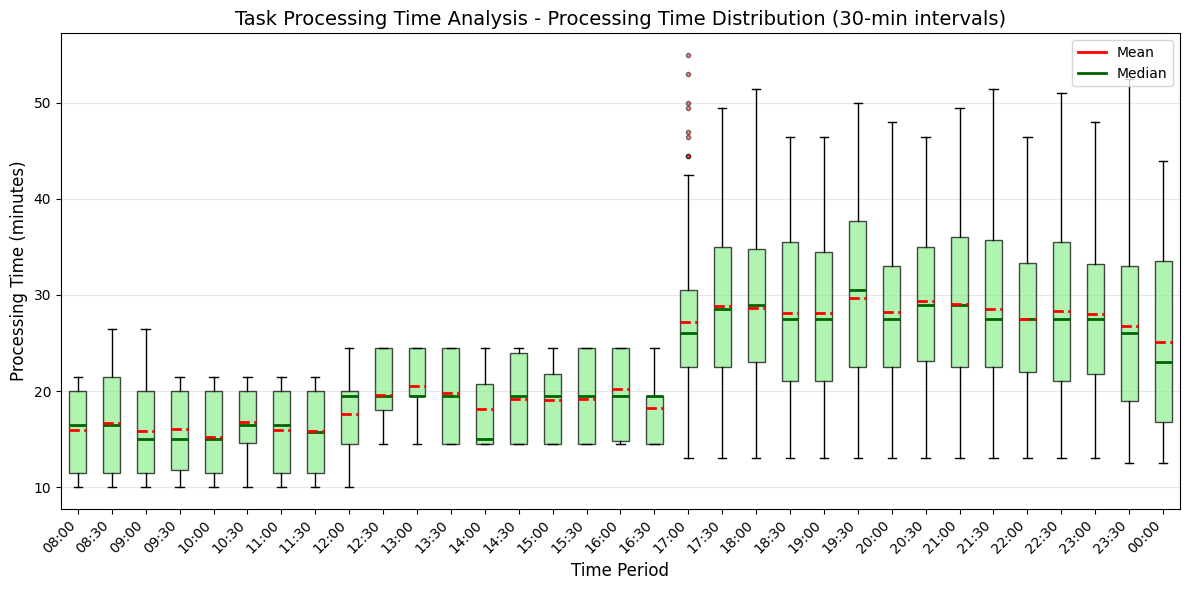

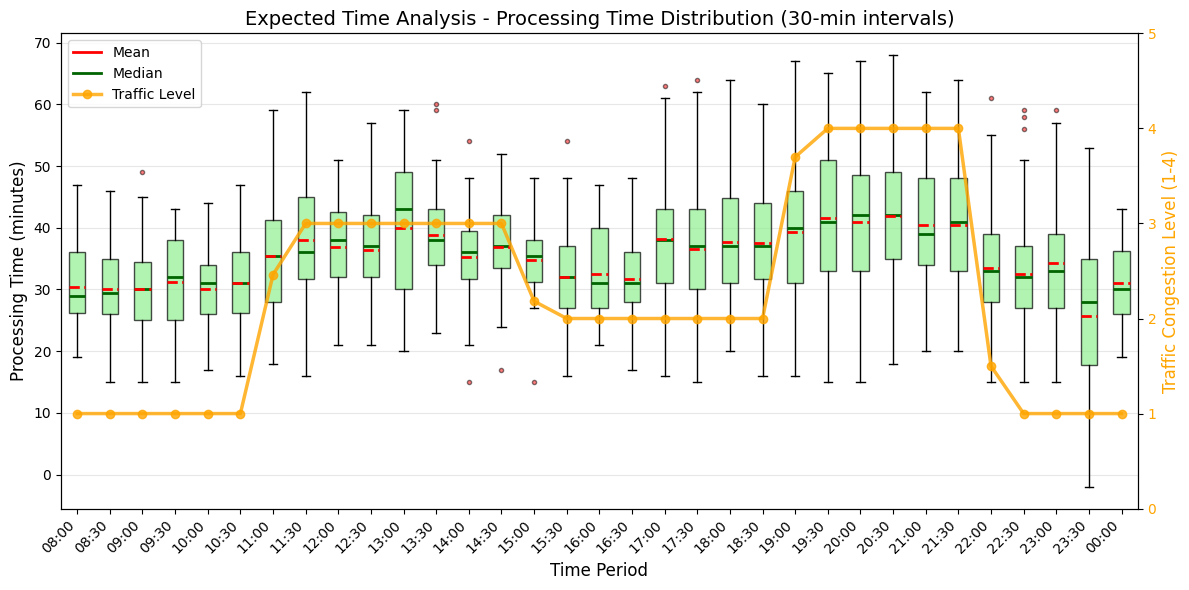

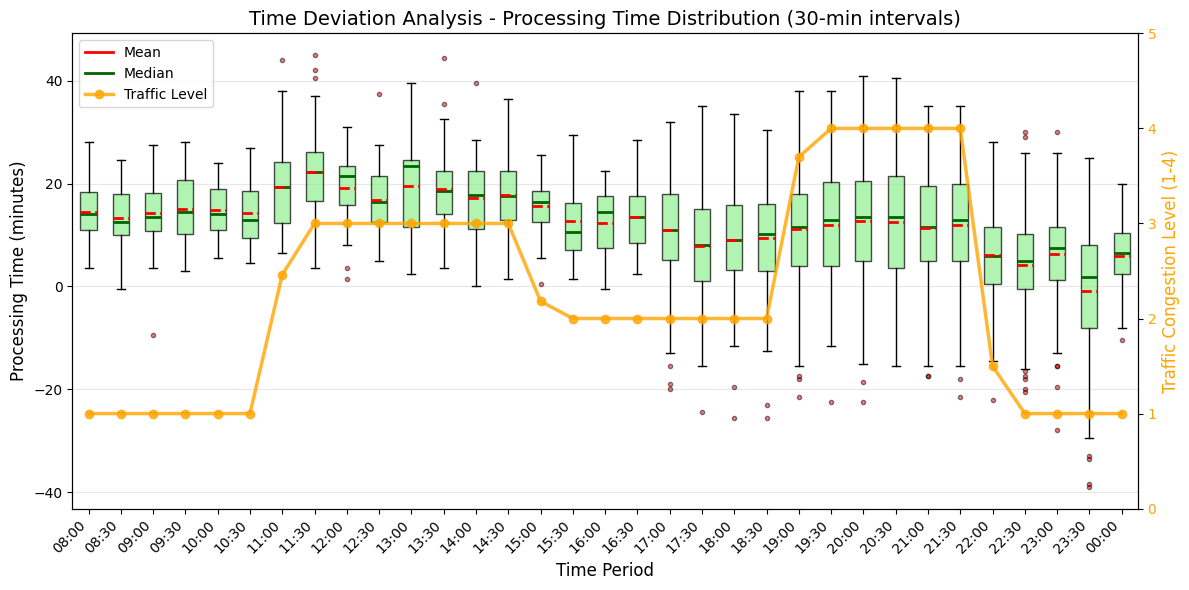

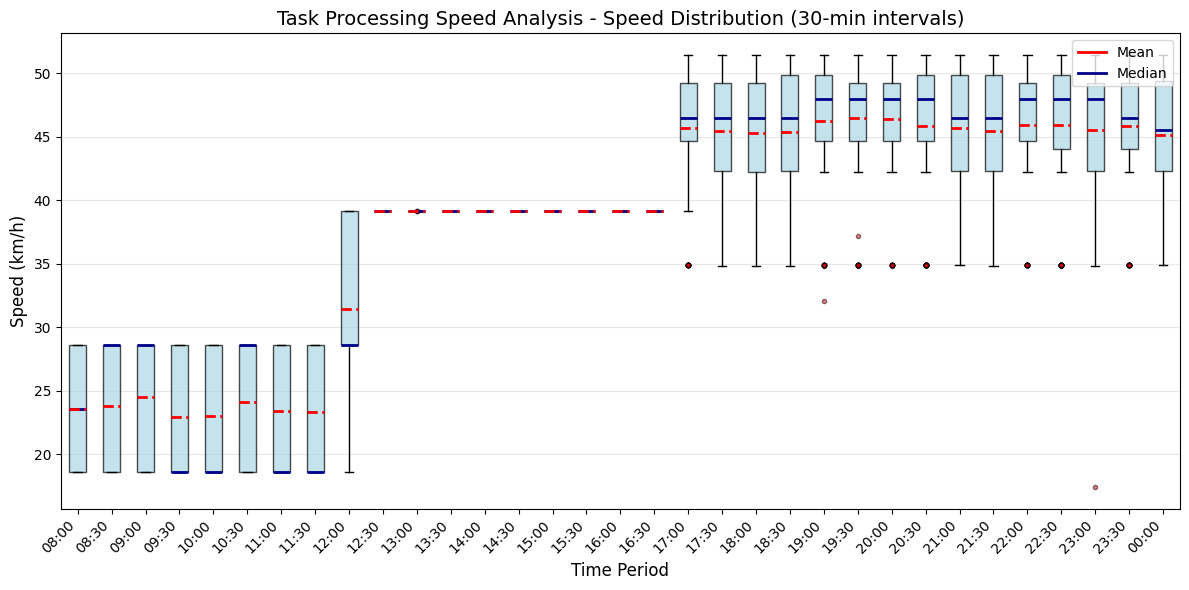

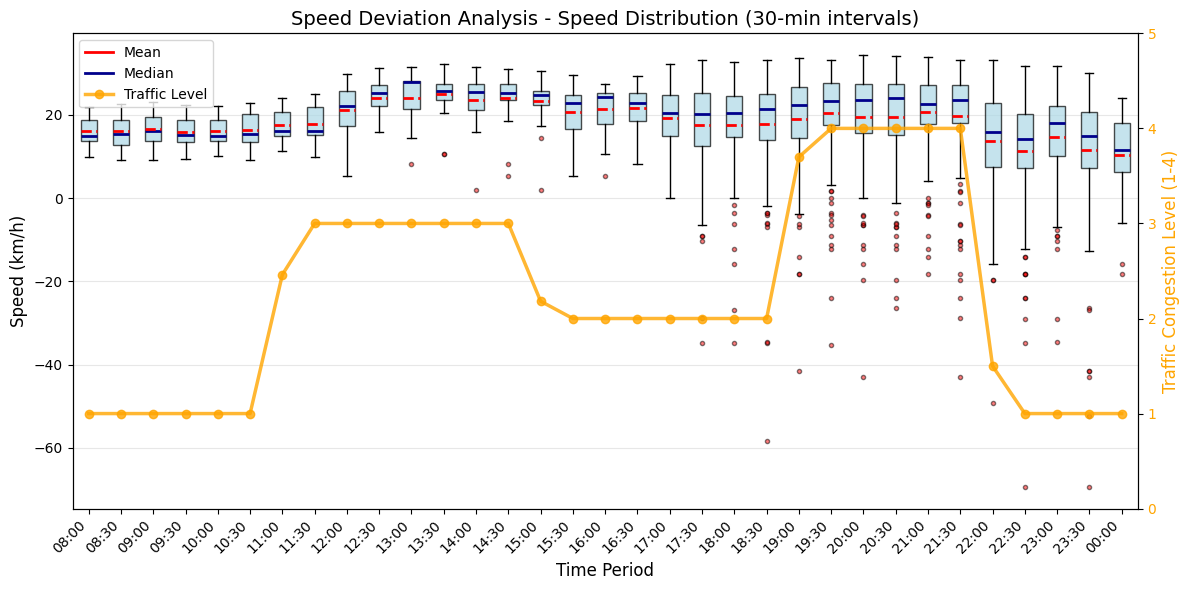

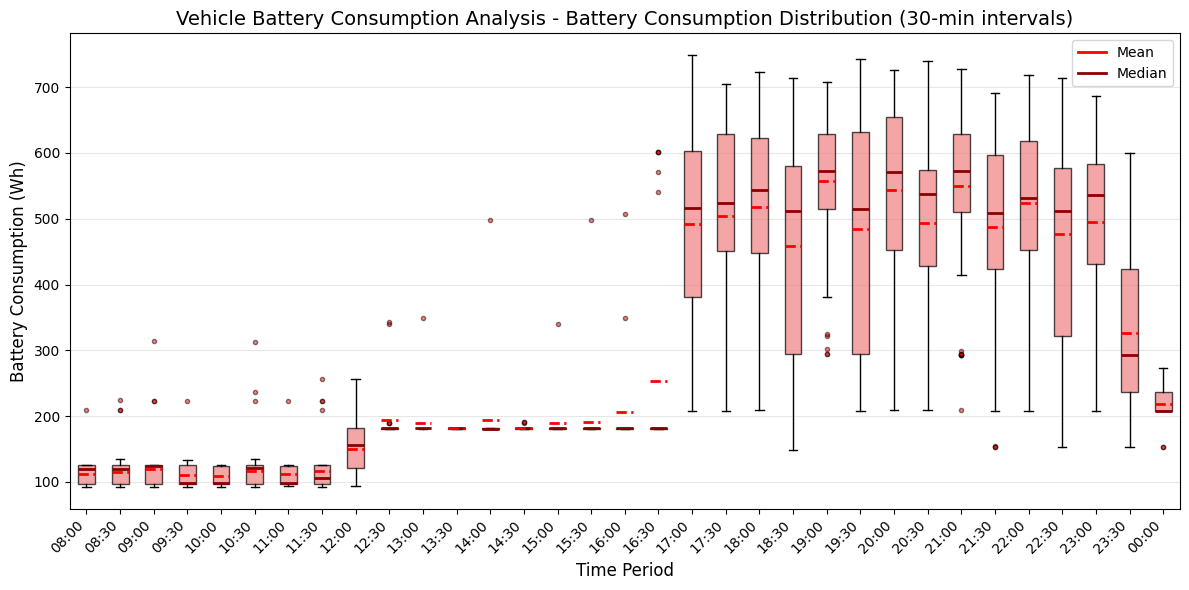

In [ ]:
p_milp.task_processing_times()
p_milp.expected_time_analysis()
p_milp.deviation_in_time_taken()
p_milp.task_speed()
p_milp.deviation_speed()
p_milp.battery_usage()
p_milp.show()